# Numerical error

Two different metrics: 

1. time reversability 
2. conservation of energy 

show this for four different systems:

1. GC center of mass in the galaxy 
2. particle in GC moving around the galaxy 
3. GC center of mass in the galaxy with a bar 
4. particle in the GC moving around the galaxy with a bar 


In [2]:
import tstrippy
import numpy as np 
import matplotlib as mpl 
from matplotlib import pyplot as plt 
from astropy import units as u
from astropy import constants as const
from astropy import coordinates as coord
import datetime
import multiprocessing as mp 
import numericalErrorFunctions as NEF
# give each object a color
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [3]:
def get_orbital_energy(xt, yt, zt, vxt, vyt, vzt, MWparams):
    """
    Calculate the orbital energy of the globular clusters.
    """
    # get the energy error
    phi = np.zeros_like(xt)
    T = np.zeros_like(xt)
    for i in range(len(xt)):
        phi[i]=tstrippy.potentials.pouliasis2017pii(MWparams, xt[i], yt[i], zt[i],)[3]
        T[i] = 0.5 * (vxt[i]**2 + vyt[i]**2 + vzt[i]**2)
    return T,phi

def compute_energy_error(E):
    """
    Compute the energy error for each globular cluster.
    """
    E0=E[:,0][:,np.newaxis]  # subtract the initial energy
    dE=E-E0
    errE = np.abs(dE / E0)  # relative error
    return errE

## 1. Energy conservation 

In [4]:
MWparams        = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      = tstrippy.Parsers.potential_parameters.MWreferenceframe()
x,y,z,vx,vy,vz  = NEF.load_globular_clusters_in_galactic_coordinates(MWrefframe)
staticgalaxy    = ["pouliasis2017pii", MWparams]
initialkinematics=[x,y,z,vx,vy,vz]
timesteps = [1e7*u.yr,1e6*u.yr,1e5*u.yr,1e4*u.yr,]
integrationtime = 5e9 * u.yr
nGCs= len(x)

inttimeIntUnits=integrationtime.to(u.s * (u.kpc/u.km))
nsteps = [int((integrationtime / timestep).value) for timestep in timesteps]
times = [np.linspace(0,inttimeIntUnits.value, nstep+1) for nstep in nsteps]


In [5]:
arg_list = [ ]
for i in range(len(times)):
    dt = timesteps[i].to(u.s * (u.kpc/u.km)).value
    nstep = nsteps[i]
    integrationparams = [0, dt, nstep]
    arg_list.append((integrationparams, staticgalaxy, initialkinematics))


ncpu = mp.cpu_count() - 2
with mp.Pool(ncpu) as pool:
    results = pool.map(NEF.vanilla_orbit, arg_list)
xts,yts,zts,vxts,vyts,vzts,compTimes = zip(*results)


In [6]:
Es = []
for i in range(len(xts)):
    T,phi = get_orbital_energy(xts[i], yts[i], zts[i], vxts[i], vyts[i], vzts[i], MWparams)
    Es.append(T + phi)

In [7]:
errE = [ ]
for i in range(len(Es)):
    errE.append(compute_energy_error(Es[i]))

In [8]:
E0=Es[0][:,0]
E0flat=E0.reshape((E0.shape[0],))
# make the colors based on the orbital energy 
cmap = mpl.cm.get_cmap('rainbow')
norm = mpl.colors.Normalize(vmin=E0flat.min(), vmax=E0flat.max())
colors = cmap(norm(E0flat))


/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_58289/2909397590.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('rainbow')


In [9]:
meanLowRes = np.mean(errE[0], axis=0)
meanHighRes = np.mean(errE[-1], axis=0)
meanEnergyErrorLeapFrog = []
for i in range(len(errE)):
    print("Mean energy error for the integration with dt = ", timesteps[i], " is ", np.mean(errE[i]))
    meanEnergyErrorLeapFrog.append(np.mean(errE[i]))

Mean energy error for the integration with dt =  10000000.0 yr  is  0.280455411372295
Mean energy error for the integration with dt =  1000000.0 yr  is  0.00026725395913197996
Mean energy error for the integration with dt =  100000.0 yr  is  3.5380483413123507e-07
Mean energy error for the integration with dt =  10000.0 yr  is  3.5403247325252093e-09


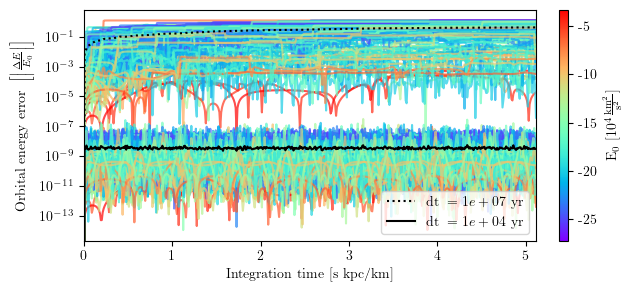

In [10]:
fig= plt.figure(figsize=(8.25-2,3))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig,width_ratios=[1, 1/50],wspace=0.1)
axis = fig.add_subplot(gs[0, 0])
caxis= fig.add_subplot(gs[0, 1])

nskip = 1 
for i in range(nGCs):
    axis.plot(times[0][::nskip],errE[0][i,::nskip],linestyle='-',color=colors[i],alpha=0.7)
axis.plot(times[0][::nskip],meanLowRes[::nskip],linestyle=':',color='black',label=r"$\mathrm{{dt}}~={:.0e}~\mathrm{{yr}}$".format(int(timesteps[0].to(u.yr).value)),)
nskip=1000
for i in range(nGCs):
    axis.plot(times[-1][::nskip],errE[-1][i,::nskip],linestyle='-',color=colors[i],alpha=0.7)
axis.plot(times[-1][::nskip],meanHighRes[::nskip],linestyle='-',color='black',label=r"$\mathrm{{dt}}~={:.0e}~\mathrm{{yr}}$".format(int(timesteps[-1].to(u.yr).value)),)
axis.set_yscale("log")
axis.set_xlim(0, inttimeIntUnits.value)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxis, label=r'$\mathrm{E_0 }~[10^4 \frac{\mathrm{km}^2}{\mathrm{s}^2}]$')
# replace the ticks of the caxis and divide them by 1e5
caxis.set_yticks(caxis.get_yticks()[1:-1])
caxis.set_yticklabels(np.array(caxis.get_yticks()[:]/1e4,dtype=int))
axis.set_xlabel(r'$\mathrm{Integration~time}~[\mathrm{s~kpc}/\mathrm{km}]$');
axis.set_ylabel(r'$\mathrm{Orbital~energy~error}~\left[\left|\frac{\Delta E}{E_0}\right|\right]$');
axis.legend()

fig.savefig("../../images/numericalErrorLeapFrogVanilla.png", bbox_inches='tight', dpi=300)

## 2. Computation time

In [11]:
nsteps = [int(integrationtime.value/timestep.value) for timestep in timesteps]
comp_time = np.array([ct.total_seconds() for ct in compTimes])
time_per_step = np.array([ct.total_seconds()/n/nGCs for ct,n in zip(compTimes, nsteps)])

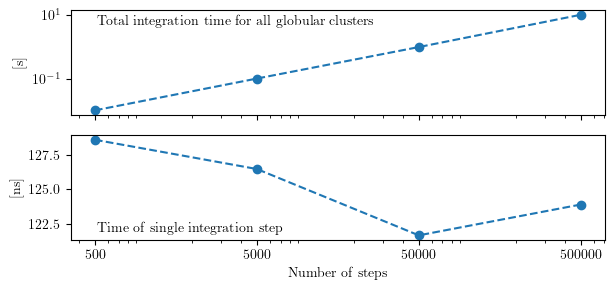

In [12]:
fig,axis=plt.subplots(2,1,figsize=(8.25-2,3),sharex=True,)
axis[0].plot(nsteps,comp_time,marker='o',linestyle='--')
axis[0].set_ylabel(r"$\mathrm{[s]}$")
axis[0].set_xscale("log")
axis[0].set_yscale("log")
axis[0].text(0.05,0.95,r"$\mathrm{Total~integration~time~for~all~globular~clusters}$",transform=axis[0].transAxes,fontsize="medium",horizontalalignment='left',verticalalignment='top')
axis[1].plot(nsteps,1e9*time_per_step,marker='o',linestyle='--')
axis[1].set_ylabel(r"$\mathrm{[ns]}$")
axis[1].set_xlabel(r"$\mathrm{Number~of~steps}$")
axis[1].set_xscale("log")
axis[1].set_xticks(nsteps);
axis[1].set_xticklabels([f"{n:.0f}" for n in nsteps])
axis[1].get_yticks()
axis[1].text(0.05,0.05,r"$\mathrm{Time~of~single~integration~step}$",transform=axis[1].transAxes,fontsize="medium",horizontalalignment='left',verticalalignment='bottom')
fig.tight_layout()
fig.savefig("../../images/numericalErrorGlobularClustersComputationTime.png",bbox_inches='tight',dpi=300)

## 4. Reverse integration 

In [13]:
arg_list = [[integrationtime,timestep,staticgalaxy,initialkinematics] for timestep in timesteps]
ncpu = mp.cpu_count() - 2
with mp.Pool(ncpu) as pool:
    results = pool.map(NEF.vanilla_clusters, arg_list)
backwardOrbit,forwardOrbit,computation_time = zip(*results)

In [14]:
relativeR,realtiveV = [],[]
for i in range(len(backwardOrbit)):
    dr, dv, rmean, vmean = NEF.get_dr_dv_rmean_vmean(backwardOrbit[i], forwardOrbit[i])
    relativeR.append(dr/rmean)
    realtiveV.append(dv/vmean)

In [15]:
# get the means for each relativeR and realtiveV
meanRealtiveRs,meanRealtiveVs = [],[]
for i in range(len(relativeR)):
    meanRealtiveRs.append(np.mean(relativeR[i], axis=0))
    meanRealtiveVs.append(np.mean(realtiveV[i], axis=0))


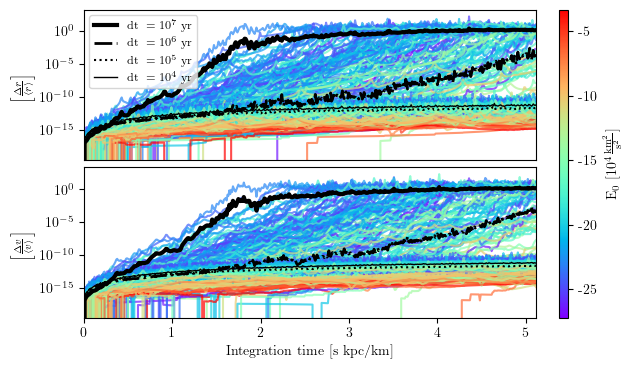

In [16]:
fig = plt.figure(figsize=(8.25-2,4))
gs = mpl.gridspec.GridSpec(2, 2, figure=fig,width_ratios=[1, 1/50],wspace=0.1,hspace=0.05)
axis1 = fig.add_subplot(gs[0, 0])
axis2 = fig.add_subplot(gs[1, 0])
caxis= fig.add_subplot(gs[:, 1])

nskips = [1, 1000]
for i in [0,-1]:
    for j in range(nGCs):
        axis1.plot(times[i][::nskips[i]],relativeR[i][j][::nskips[i]],linestyle='-',color=colors[j],alpha=0.7)
        axis2.plot(times[i][::nskips[i]],realtiveV[i][j][::nskips[i]],linestyle='-',color=colors[j],alpha=0.7)

nskips = [1,10,100,1000]
linewidths = [3,2,1.5,1]
linestyles = ['-', '-.', ':', '-']
for i in range(0,4):
    dt_val = int(timesteps[i].to(u.yr).value)
    exponent = int(np.log10(dt_val))
    label = r"$\mathrm{{dt}}~=10^{{{}}}~\mathrm{{yr}}$".format(exponent)
    # axis1.plot(times[i][::nskips[i]],meanRealtiveRs[i][::nskips[i]],linewidth=linewidths[i],color = "k", linestyle=linestyles[i],label=r"$\mathrm{{dt}}~={:.0e}~\mathrm{{yr}}$".format(int(timesteps[i].to(u.yr).value)))
    axis1.plot(times[i][::nskips[i]],meanRealtiveRs[i][::nskips[i]],linewidth=linewidths[i],color = "k", linestyle=linestyles[i],label=label)
    axis2.plot(times[i][::nskips[i]],meanRealtiveVs[i][::nskips[i]],linewidth=linewidths[i],color = "k", linestyle=linestyles[i])

axis1.set_ylabel(r"$\left[\frac{\Delta r}{\langle r \rangle}\right]$")
axis2.set_ylabel(r"$\left[\frac{\Delta v}{\langle v \rangle}\right]$")
axis1.set_xticks([])
axis1.set_yscale("log")
axis2.set_yscale("log")

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxis, label=r'$\mathrm{E_0 }~[10^4 \frac{\mathrm{km}^2}{\mathrm{s}^2}]$')
caxis.set_yticks(caxis.get_yticks()[1:-1])
caxis.set_yticklabels(np.array(caxis.get_yticks()[:]/1e4,dtype=int));

axis1.legend(fontsize="small")
axis1.set_xlim(0, inttimeIntUnits.value)
axis2.set_xlabel(r"$\mathrm{Integration~time}~[\mathrm{s~kpc}/\mathrm{km}]$")
axis2.set_xlim(0, inttimeIntUnits.value)

fig.savefig("../../images/numericalErrorReverseIntegration.png",bbox_inches='tight',dpi=300)

# 5. Forest-Ruth

Let's look at the computation time and conservation of energy for this system 

In [17]:
arg_list = [ ]
for i in range(len(times)):
    dt = timesteps[i].to(u.s * (u.kpc/u.km)).value
    nstep = nsteps[i]
    integrationparams = [0, dt, nstep]
    arg_list.append((integrationparams, staticgalaxy, initialkinematics))

ncpu = mp.cpu_count() - 2
with mp.Pool(ncpu) as pool:
    results = pool.map(NEF.vanilla_orbit_forest_ruth, arg_list)
xts,yts,zts,vxts,vyts,vzts,compTimes = zip(*results)

In [18]:
time_per_step_ruth_forest = [compTime.total_seconds()/nstep/nGCs for compTime,nstep in zip(compTimes, nsteps)]
mean_comp_time_per_step = np.mean(time_per_step_ruth_forest)*1e9
mean_comp_time_per_step=int(mean_comp_time_per_step)
print(mean_comp_time_per_step, "in nano seconds")

495 in nano seconds


In [19]:
# get the energy error
errE_ruth = []
for i in range(len(xts)):
    T,phi = get_orbital_energy(xts[i], yts[i], zts[i], vxts[i], vyts[i], vzts[i], MWparams)
    errE_ruth.append(compute_energy_error(T + phi))    

In [ ]:
# get the meanEnergyError for each timestep checked 
meanEnergyError_ruth = []
stdEnergyError_ruth = []
for i in range(len(errE_ruth)):
    meanEnergyError_ruth.append(np.mean(errE_ruth[i], axis=0))
    stdEnergyError_ruth.append(np.std(errE_ruth[i], axis=0))

mean_per_time_step_ruth = []
for i in range(len(meanEnergyError_ruth)):
    mean_per_time_step_ruth.append(np.mean(meanEnergyError_ruth[i]))

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_58289/3023057649.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('rainbow')


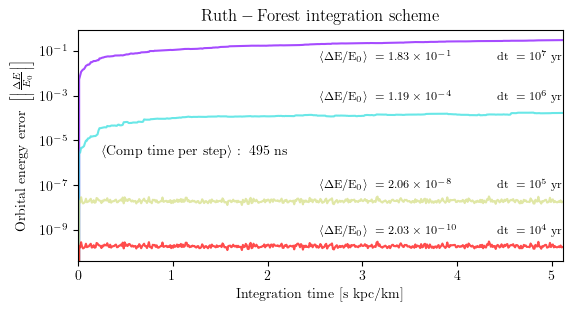

In [23]:
meanEnergyError_ruth[0].mean()
fig,axis = plt.subplots(figsize=(8.25-2,3))
cmap = mpl.cm.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(nsteps)))
nskips = [1, 10, 100, 1000]
for i in range(len(nsteps)):
    dt_val = int(timesteps[i].to(u.yr).value)
    exponent = int(np.log10(dt_val))
    text = r"$\mathrm{{dt}}~=10^{{{}}}~\mathrm{{yr}}~$".format(exponent)
    exponent = int(np.log10(mean_per_time_step_ruth[i]))
    # Get the log value
    log_val = np.log10(mean_per_time_step_ruth[i])
    # Get the integer part
    int_part = int(log_val)
    # Calculate the decimal part
    decimal_part = log_val - int_part
    # Format the scientific notation properly
    mantissa = 10**(decimal_part) * 10 
    exponent = int_part - 1
    formatted_value = f"{mantissa:.2f}×10^{{{exponent}}}" 
    text2= r"$\mathrm{{\langle \Delta E / E_0 \rangle}}~={{{:.2f}}}\times 10^{{{}}}$".format(mantissa, exponent)
    axis.plot(times[i][::nskips[i]], meanEnergyError_ruth[i][::nskips[i]], linestyle='-',  label=label,color=colors[i], alpha=0.7)
    if i ==0: 
        va = "top"
        frac = (1/3)
    else:
        va = "bottom"
        frac = (3/1)
    axis.text(times[i][-1], frac*meanEnergyError_ruth[i][-1], text, fontsize="small", color="k", ha='right', va=va)
    axis.text((1/2)*times[i][-1], frac*meanEnergyError_ruth[i][-1], text2, fontsize="small", color="k", ha='left', va=va)


text = r"$\langle \mathrm{{Comp~time~per~step}} \rangle:~{{{}}}~\mathrm{{ns}}$".format(mean_comp_time_per_step)
axis.text(0.05, 0.50, text, transform=axis.transAxes, fontsize="medium", horizontalalignment='left', verticalalignment='top')
axis.set_xlim(0, inttimeIntUnits.value)
axis.set_yscale("log")
axis.set_xlabel(r'$\mathrm{Integration~time}~[\mathrm{s~kpc}/\mathrm{km}]$');
axis.set_ylabel(r'$\mathrm{Orbital~energy~error}~\left[\left|\frac{\Delta E}{E_0}\right|\right]$');
axis.set_title(r"$\mathrm{Ruth-Forest~integration~scheme}$")
fig.savefig("../../images/numericalErrorRuthForest.png", bbox_inches='tight', dpi=300)

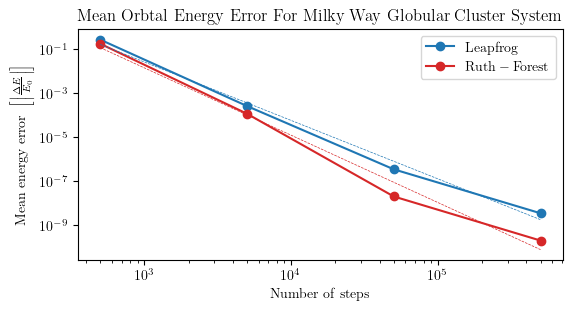

In [24]:
mRF,bRF=np.polyfit(np.log10(nsteps), np.log10(mean_per_time_step_ruth), 1)
mLF,bLF=np.polyfit(np.log10(nsteps), np.log10(meanEnergyErrorLeapFrog), 1)
fig,axis = plt.subplots(figsize=(8.25-2,3))
axis.plot(nsteps, meanEnergyErrorLeapFrog, marker='o', linestyle='-',color="tab:blue", label=r"$\mathrm{Leapfrog}$")
axis.plot(nsteps, mean_per_time_step_ruth, marker='o', linestyle='-',color="tab:red", label=r"$\mathrm{Ruth-Forest}$")
# plot the fit lines 
axis.plot(nsteps, 10**(bRF + mRF * np.log10(nsteps)), linestyle='--', color="tab:red", linewidth=0.5)
axis.plot(nsteps, 10**(bLF + mLF * np.log10(nsteps)), linestyle='--', color="tab:blue", linewidth=0.5)
# set the x and y scale to log
axis.set_yscale("log")
axis.set_xscale("log")
axis.set_xlabel(r"$\mathrm{Number~of~steps}$")
axis.set_ylabel(r"$\mathrm{Mean~energy~error}~\left[\left|\frac{\Delta E}{E_0}\right|\right]$")
axis.set_title(r"$\mathrm{Mean~Orbtal~Energy~Error~For~Milky~Way~Globular~Cluster~System}$")
axis.legend()
fig.savefig("../../images/numericalErrorMeanEnergyErrorRuthForestLeapFrog.png", bbox_inches='tight', dpi=300)

In [25]:
# given an error of 1e-8, what's the difference in the number of steps needed to reach it?
nsteps_ruth = 10**((np.log10(1e-8) - bRF) / mRF)
nsteps_leapfrog = 10**((np.log10(1e-8) - bLF) / mLF)
print("Mean step speed leapfrog: ", np.mean(time_per_step))
print("Mean step speed Ruth-Forest: ", np.mean(time_per_step_ruth_forest))
print(f"Number of steps needed for Ruth-Forest to reach an error of 1e-8: {nsteps_ruth:.0f}")
print(f"Number of steps needed for Leapfrog to reach an error of 1e-8: {nsteps_leapfrog:.0f}")
# now the average time per step 
timeRuth=np.mean(time_per_step_ruth_forest) * nsteps_ruth
timeLeapFrog=np.mean(time_per_step) *nsteps_leapfrog

print(f"Average for Ruth-Forest: {timeRuth:.3f} seconds")
print(f"Average for Leapfrog: {timeLeapFrog:.3f} seconds")
print(f"Leapfrog is {timeRuth/timeLeapFrog:.3f} times faster than Ruth-Forest")

Mean step speed leapfrog:  1.2515544848484848e-07
Mean step speed Ruth-Forest:  4.95288709090909e-07
Number of steps needed for Ruth-Forest to reach an error of 1e-8: 102773
Number of steps needed for Leapfrog to reach an error of 1e-8: 262641
Average for Ruth-Forest: 0.051 seconds
Average for Leapfrog: 0.033 seconds
Leapfrog is 1.549 times faster than Ruth-Forest


In [26]:
((5*u.pc)*1e-8).to(u.au)

<Quantity 0.01031324 AU>